In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

# Setup

In [2]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [3]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [4]:
model.find_ss(0.50,do_print=True)

Labor supply and search and matching:
ss.S = 7.44,  ss.L = 56.28,  ss.delta_L = 0.07,  ss.v = 16.52,  ss.m_v = 0.23
Capital agency FOC:
ss.r_K = 0.14
Production firm pricing:
ss.r_ell = 2.71
Labor agency:
ss.ell = 55.87,  ss.w = 2.68
Government:
ss.B_G = 0.00,  ss.G = 0.00,  ss.tau = 0.00
Households:
solving for household behavior: result.converged = True
ss.C = 169.41,  ss.B = 464.97
Production firm FOCs:
ss.K = 557.43
Capital accumulation equation:
ss.I = 55.74
Output in production firm:
ss.Y = 229.56
Market clearing:
ss.C_Y = 118.59,  ss.G_Y = 0.00,  ss.I_Y = 36.23,  ss.X_Y = 74.74
[ ss.C_M = 50.82,  ss.G_M = 0.00,  ss.I_M = 19.51,  ss.X_M = 49.83 ] = ss.M = 120.16
ss.X = 124.57
Bargaining:
par.phi = 0.988


**Household behavior:**

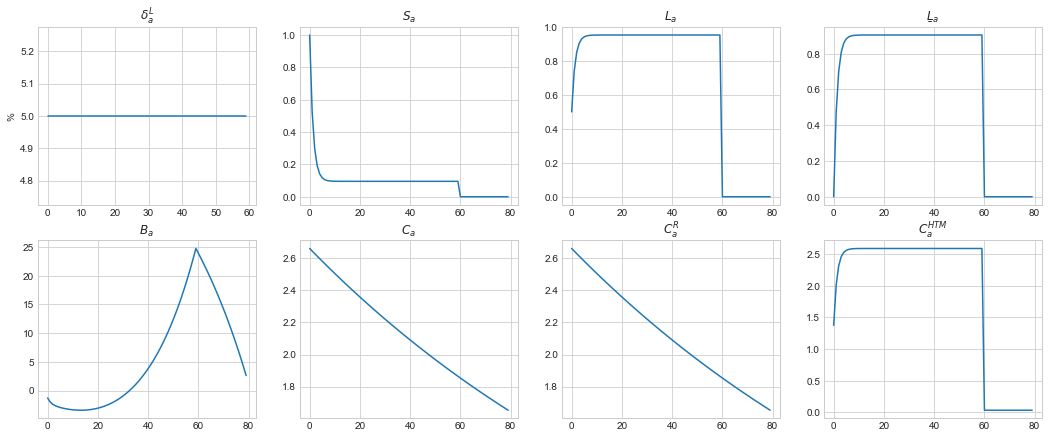

In [5]:
fig = plt.figure(figsize=(3*6,3*6/2.5))

ax = fig.add_subplot(2,4,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(2,4,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(2,4,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(2,4,4)
ax.plot(model.ss.L_ubar_a)
ax.set_title(r'$L\underbar_a$')

ax = fig.add_subplot(2,4,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$')

ax = fig.add_subplot(2,4,6)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(2,4,7)
ax.plot(model.ss.C_R)
ax.set_ylabel('')
ax.set_title('$C^R_a$')

ax = fig.add_subplot(2,4,8)
ax.plot(model.ss.C_HTM)
ax.set_ylabel('')
ax.set_title('$C^{HTM}_a$');

# Speed and error tests

In [6]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [7]:
%time model.evaluate_blocks(py=True)

Wall time: 2.31 s


**Check errors:**

In [8]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 1.80e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 0.00e+00


**First numba evaluation:**

In [9]:
%time model.evaluate_blocks()

Wall time: 23.1 s


**Time:**

In [10]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

5.37 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.7 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%timeit model.evaluate_blocks(py=True)

234 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [12]:
model.calc_jac(do_print=True)

Jacobian calculated in 13.8 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [13]:
model.set_exo_ss()

Here we shock export demand:

In [14]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
sol.chi[:Tshock] = ss.chi + shock*persistence

Check errors when guessing at steady state -> excess demand

In [15]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 2.87e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 7.47e-01


**Find IRF:**

In [16]:
model.find_IRF()

initial:
   max. abs. error = 7.47e-01
    0.00e+00 in bargaining_cond
    2.87e-12 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    7.47e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 7.47e-01
    1.39e-05 in bargaining_cond
    1.83e-03 in Bq_match
    8.11e-06 in FOC_capital_agency
    2.51e-04 in FOC_K_ell
    6.60e-03 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 6.60e-03
    5.43e-07 in bargaining_cond
    4.41e-05 in Bq_match
    3.59e-07 in FOC_capital_agency
    9.70e-06 in FOC_K_ell
    2.01e-04 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 2.01e-04
    1.59e-08 in bargaining_cond
    1.37e-06 in Bq_match
    1.09e-08 in FOC_capital_agency
    2.81e-07 in FOC_K_ell
    5.74e-06 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 3
 s

**Plot:**

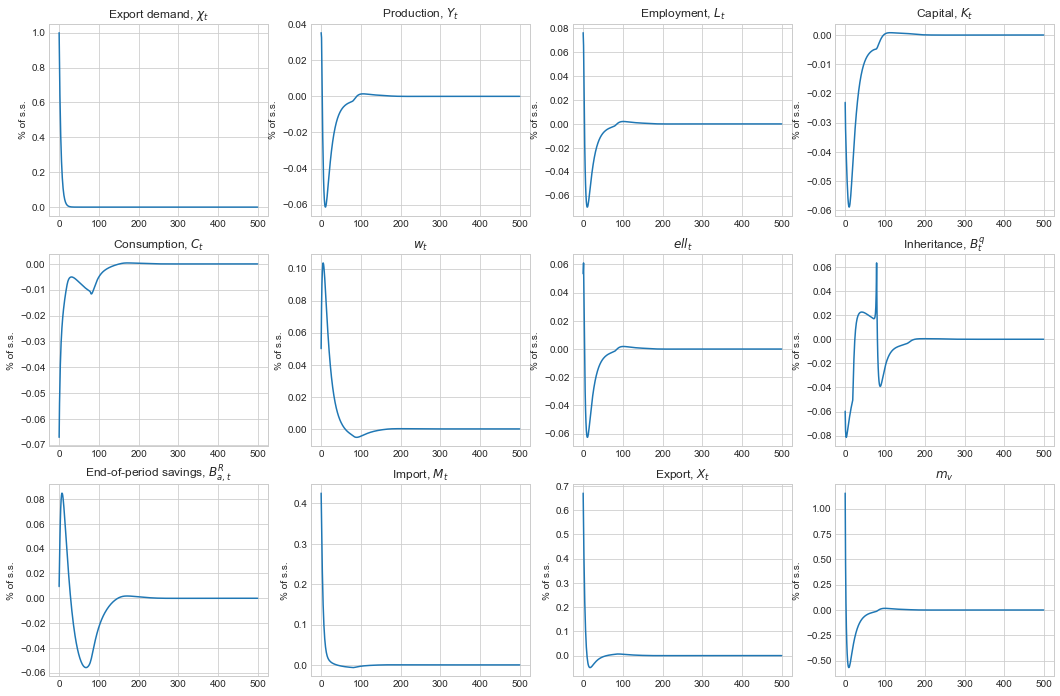

In [36]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,4,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,4,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,4,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,4,6)
ax.plot((sol.w[:T_IRF]/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$w_t$')

ax = fig.add_subplot(3,4,7)
ax.plot((sol.ell[:T_IRF]/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$ell_t$')

ax = fig.add_subplot(3,4,8)
ax.plot((sol.Bq[:T_IRF]/(ss.Bq)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Inheritance, $B^q_t$')

ax = fig.add_subplot(3,4,9)
ax.plot((sol.B[:T_IRF]/(ss.B)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('End-of-period savings, $B^R_{a,t}$')

ax = fig.add_subplot(3,4,10)
ax.plot((sol.M[:T_IRF]/(ss.M)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import, $M_t$')

ax = fig.add_subplot(3,4,11)
ax.plot((sol.X[:T_IRF]/(ss.X)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export, $X_t$')

ax = fig.add_subplot(3,4,12)
ax.plot((sol.m_s[:T_IRF]/(ss.m_s)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('$m_v$');

In [35]:
(sol.Bq[par.A-2:par.A+2]/ss.Bq-1)*100

array([0.03842378, 0.06328054, 0.02368833, 0.00080039])

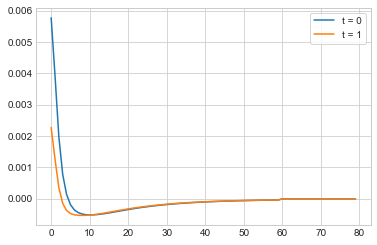

In [42]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
#ax.plot(ss.C_a,label=f'ss')
for t in [0,1]:
    L_a = np.zeros(par.A)
    for a in range(par.A):
        L_a[a] = sol.L_a[a,t+a]
    ax.plot(L_a-ss.L_a,label=f'{t = }')
ax.legend(frameon=True)

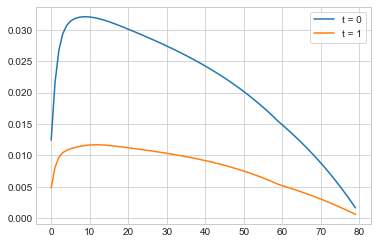

In [43]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
#ax.plot(ss.C_a,label=f'ss')
for t in [0,1]:
    B_a = np.zeros(par.A)
    for a in range(par.A):
        B_a[a] = sol.B_a[a,t+a]
    ax.plot(B_a-ss.B_a,label=f'{t = }')
ax.legend(frameon=True)

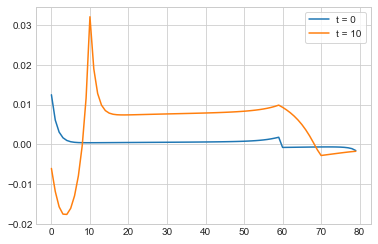

In [22]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
#ax.plot(ss.B_a,label=f'ss')
for t in [0,10]:
    ax.plot(sol.B_a[:,t]-ss.B_a,label=f'{t = }')
ax.legend(frameon=True)

# Comparison

In [18]:
model_copy = model.copy()
model_copy.par.Lambda = 0.01
model_copy.find_ss(0.50)
model_copy.calc_jac(do_print=True)

Jacobian calculated in 13.8 secs secs


In [23]:
Tshock = 50
shock = 0.01*ss.chi
persistence = 0.8**np.arange(Tshock)
model_copy.sol.chi[:Tshock] = model_copy.ss.chi + shock*persistence

In [24]:
model_copy.find_IRF()

initial:
   max. abs. error = 7.47e-01
    0.00e+00 in bargaining_cond
    5.62e-01 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    7.47e-01 in mkt_clearing

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 7.47e-01
    3.50e-05 in bargaining_cond
    5.53e-03 in Bq_match
    1.61e-05 in FOC_capital_agency
    6.13e-04 in FOC_K_ell
    1.36e-02 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 1.36e-02
    2.53e-06 in bargaining_cond
    3.75e-04 in Bq_match
    1.23e-06 in FOC_capital_agency
    4.26e-05 in FOC_K_ell
    8.47e-04 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.2 secs
   max. abs. error = 8.47e-04
    6.53e-08 in bargaining_cond
    1.14e-05 in Bq_match
    3.31e-08 in FOC_capital_agency
    1.07e-06 in FOC_K_ell
    2.05e-05 in mkt_clearing
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 3
 s

Text(0.5, 1.0, 'Production, $Y_t$')

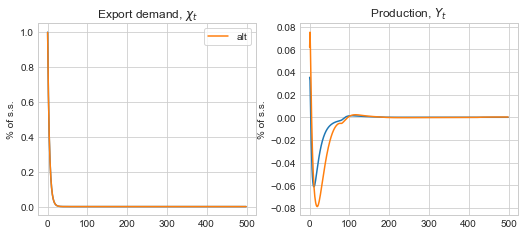

In [25]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,4,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.plot((model_copy.sol.chi[:T_IRF]/model_copy.ss.chi-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')
ax.legend(frameon=True)

ax = fig.add_subplot(3,4,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.plot((model_copy.sol.Y[:T_IRF]/model_copy.ss.Y-1)*100,label='alt')
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')